# Using Persistent Cup Products for Dissonance Detection

### MSRI-UP 2023

Authors: Kimberly Herrera, Martin Martinez, Austin MBaye 

Date: 07/21/2023

In [1]:
#import important libraries 
import time
import wave
import pyaudio
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from sklearn.cluster import KMeans
import tadasets
from itertools import combinations
from scipy.fft import fft, fftfreq, fftshift
%matplotlib inline

### Goal
We want to take a time series $f$, and detect any quasiperiodic behavior. To do this, we present the following algorithm that takes the two highest points in $H_1$ in the persistence diagram of the Rips filtration on the sliding window point cloud of $f$, takes the cup product between them, and plots the product on the diagram. Should this new point be highly persistent, then the time series is quasiperiodic. The motivation behind this is that quasiperiodic functions produce point clouds that are dense in tori, so we want their persistence diagram to "match" that of a torus with the addition of the cup product to confirm that the function has the correct structure.

We will apply this algorithm on music to detect dissonance. This will work because when you have dissonance, the frequencies of the music notes are linearly independent of each other so you get a quasiperiodic signal.

#### For the next cell, put your volume up!

In [2]:
# need to make the wav file available for download before running

In [3]:
# Open the WAV file
wav_file = wave.open('C:/Users/kimbe/Downloads/0_noise.wav', 'rb') #kimbe will need to be replaced with your username

# Create an instance of the PyAudio class
audio_player = pyaudio.PyAudio()

# Open a stream to play the audio
stream = audio_player.open(format=audio_player.get_format_from_width(wav_file.getsampwidth()),
                           channels=wav_file.getnchannels(),
                           rate=wav_file.getframerate(),
                           output=True)

# Read the audio data in chunks and play it
chunk_size = 1024
data = wav_file.readframes(chunk_size)

while data:
    stream.write(data)
    data = wav_file.readframes(chunk_size)

# Stop and close the stream
stream.stop_stream()
stream.close()

# Terminate PyAudio
audio_player.terminate()

# Close the WAV file
wav_file.close()

In [15]:
# Import wave file
file_path = 'C:/Users/kimbe/Downloads/0_noise.wav'
sample_rate, audio_data = wavfile.read(file_path)

# Define start and end times (in seconds)
start_time = 0.0
end_time = 0.1

# Convert the time values to corresponding sample indices
start_index = int(start_time * sample_rate)
end_index = int(end_time * sample_rate)

# Trim the audio data array
audio_data = audio_data[start_index:end_index]

# Convert stereo to mono
if audio_data.ndim > 1:
    audio_data = audio_data.mean(axis=1)
duration = (len(audio_data) / sample_rate) * 1000
real_time = np.linspace(0, duration, len(audio_data))

<ipython-input-15-40a3bb9c8609>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(file_path)


#### Now let's look at the formula for the time series of this sound!

There are two independent frequencies, 1046.502 Hz and 1479.98 Hz (where the second is an irrational multiple of the first).
We have:  <h3 align="center"> $ f(x) = \sin(1046.502 \cdot 2\pi \cdot x) + \sin(1046.502\sqrt2  \cdot 2\pi \cdot x)$ </h3>.

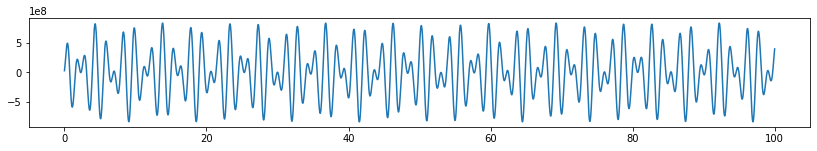

In [23]:
plt.figure(figsize = (14,2))
plt.plot(real_time, audio_data);

### Step 1: Function &#8594; Point Cloud
When applying sliding windows to a time series, a window of fixed size slides along the data, and the points within the window are collected to form a point cloud. The embedding dimension ($d$) refers to the number of dimensions/features used to represent each point in the sliding window. The time delay ($\tau$) specifies the time lag between the starting positions of adjacent windows. The delay can be thought of as the step size used to slide the window along the data. We want to optimize the values of $d$ and $\tau$ before applying sliding windows.

##### Finding $d$ : 
We want to compute a Fast Fourier Transform (FFT). This takes a series given by amplitude vs. time and returns it as amplitude vs. frequency, that way we can determine which frequency peaks in the time series are the strongest. The number of prominent peaks is what determines $d$.

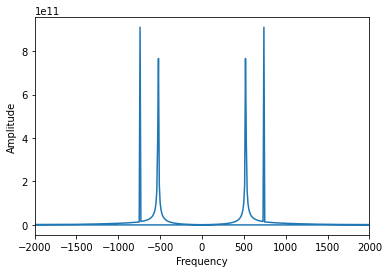

In [28]:
# Perform FFT
fft_result = np.fft.fft(audio_data)

# Compute the frequencies corresponding to the FFT result
sample_rate = 1 / (real_time[1] - real_time[0])  # Sampling rate
frequencies = np.fft.fftfreq(len(audio_data), 1 / sample_rate)

plt.plot(frequencies * 1000, np.abs(fft_result))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim([-2000, 2000])
plt.show()

How many peaks do you see? 

In [31]:
d = 4

In [32]:
unsorted_fft = []
for i in range(len(frequencies)):
    if i % 1000 == 0:
        print("on loop " + str(i) + " of " + str(len(frequencies)))
    if frequencies[i] * 1000 >= 0:
        pair = (frequencies[i] * 1000, np.abs(fft_result)[i])
        unsorted_fft.append(pair)
fft_array = sorted(unsorted_fft, key=lambda x: x[1], reverse=True) #find strongest frequency

on loop 0 of 4410
on loop 1000 of 4410
on loop 2000 of 4410
on loop 3000 of 4410
on loop 4000 of 4410


##### Finding $\tau$ :
We want a $\tau$ that miminizes the following equation:
 
$\displaystyle \Gamma(x) = \sum_{k \neq k'} \left\vert 1 + e^{ix \langle k - k', \omega \rangle} + \ldots + e^{ix \langle k - k', \omega \rangle d} \right\vert^2$.

This sums over every pair of distinct peaks, k and k' are the frequency values of the two distinct prominent peaks. 

In [19]:
prominent_peaks = []

for i in range(d):
    prominent_peaks.append(fft_array[i][0])

prominent_peaks

[739.8321995464853, 519.8820861678005, 529.8798185941043, 509.8843537414967]

In [20]:
def tau_sum(tau): #tau is x in the equation above
    '''Computes sum for prominent peaks'''
    tau_sum = 0
    for i in range(len(prominent_peaks)):
        for j in range(i):
            re_sum = 1
            im_sum = 0
            for k in range(d + 1):
                re_sum += np.cos((prominent_peaks[i] - prominent_peaks[j]) * tau * k)
                im_sum += np.sin((prominent_peaks[i] - prominent_peaks[j]) * tau * k)
            tau_sum += (re_sum ** 2) + (im_sum ** 2)
    return tau_sum

In [21]:
'''Check different values of tau and minimize'''
tau_vals = np.linspace(0, np.pi, 1000)

min_sum = 100000000000000000000
best_tau = None
for tau in tau_vals:
    if tau_sum(tau) < min_sum:
        min_sum = tau_sum(tau)
        best_tau = tau
        
print(best_tau)
print(min_sum)

0.5031579825569238
5.812843474105355


#### Now that we have all the optimal parameters, we can compute the sliding window point cloud:

In [ ]:
def SW_cloud(f, tau, d, n_data):
    # Inputs:
    # f : time series -- array of size (2,N) (x and y values) or (1,N) (only y values)
    #For simplicity, we will assume that f, our time series is a nested list of two lists, each with x1, x2, ... xn and y1, y2,... and yn respectively.
    # tau: delay -- positive real number
    # d : gives embedding dimension d+1 -- integer
    # n_data : desired number of points in SW point cloud -- intenger
    #
    # Output:
    # SW : sliding window point cloud -- array of size (n_data,  d+1)

    #Step 1: turn f into a cubic spline
        x_vals = f[0]
        y_vals = f[1]
        cs = CubicSpline(x_vals, y_vals)


    #Step 2: create the t values where to evaluate SW_f
        t_vals = np.linspace(np.min(x_vals),np.max(x_vals)-d*tau,n_data)
 

    #Step 3: evaluate the sliding window point cloud
        SW=[]
        for t in t_vals:
            SW_f_t=cs(t + np.arange(0,d+1)*tau)
            SW.append(SW_f_t)
        SW=np.array(SW)

 

        return SW

In [ ]:
SW_f = SW_cloud(f, best_tau, d, 1000) #point cloud for our time series!

### Step 2: Point Cloud &#8594; Persistence Diagram via Ripser

Now that we have a point cloud, we want to compute a persistence diagram. The Ripser library we imported at the start does this for us, but let's go over what it does! 

First we need to compute a Rips filtration on the point cloud:
1. Compute the pairwise distance between all points in the cloud.
2. Pick a distance threshold $\alpha$ and connects points that are within $\alpha$ of each other. This creates new simplices for our simplicial complex.

We continue increasing $\alpha$ until all points in our cloud are connected. As $\alpha$ increases, simplices of higher dimension are created such as triangles and tetrahedra. Once everything is connected, we're left with a simplicial complex!

Ripser then takes the simplicial complex and computes the barcode, which consists of intervals representing a topological feature in our data(connected component, hole, etc). The intervals indicate the birth and death (or persistence) of the features as the filtration progresses. The length of an interval represents the feature's persistence. Ripser first construct the total boundary matrix from the simplicial complex and then reduces it to extract the barcode.

This is then visualized as:

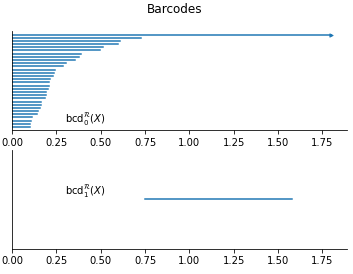

or as a persistence diagram:

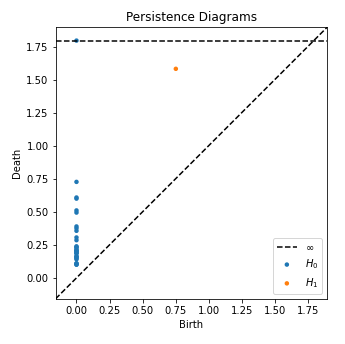

#### Now lets do this for our time series!

In [ ]:
result = ripser(SW_f, coeff=2, do_cocycles=True) 
diagrams = result['dgms']
cocycles = result['cocycles'] #all of the cocycles
D = result['dperm2all'] #distance matrix between the ith and jth points in the data
dgm1 = diagrams[1]

We also want to extract all of the cocycles. Cocycles are defined:

$C^n(K; \mathbb{F}) = \{\varphi:K^{(n)} \rightarrow \mathbb{F} \;\; \textit{s.t.} \;\;\#(supp(\varphi)) < \infty\}$ 

These are in the kernel of $\delta^{n+1}$ but not in the image of $\delta^n$.

### Step 3: Finding $\varphi$ and $\psi$

In [ ]:
#Representative cocycle phi
idx1 = np.argmax(dgm1[:, 1] - dgm1[:, 0])
cocycle1 = cocycles[1][idx1]
#Representative cocycle psi
sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0])
idx2 = sorted_indices[-2]
cocycle2 = cocycles[1][idx2]

In [ ]:
#Restrict cocycle1
New_cocycle1=[]
edges=[]
for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i:i-1, :2], cocycle1[i:i+1, :2], cocycle2[j:j+1, :2]):  
                New_cocycle1.append(cocycle2[j:j+1])
        New_cocycle1.append(cocycle2[i:i+1])        
rcocycle1=np.vstack(New_cocycle1)
for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i-1:i, :2], cocycle2[j:j+1, :2]):
                edges.append(cocycle2[j:j+1])        
edges=np.vstack(edges)
for i in range(len(rcocycle1)):
    found_match = False
    for j in range(len(edges)):
        if np.array_equal(rcocycle1[i, :2], edges[j, :2]):
            found_match = True
            break
    if not found_match:
        rcocycle1[i, -1] = 0

In [ ]:
#Restrict cocycle1
New_cocycle1=[]
edges=[]
for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i:i-1, :2], cocycle1[i:i+1, :2], cocycle2[j:j+1, :2]):  
                New_cocycle1.append(cocycle2[j:j+1])
        New_cocycle1.append(cocycle2[i:i+1])        
rcocycle1=np.vstack(New_cocycle1)
for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i-1:i, :2], cocycle2[j:j+1, :2]):
                edges.append(cocycle2[j:j+1])        
edges=np.vstack(edges)
for i in range(len(rcocycle1)):
    found_match = False
    for j in range(len(edges)):
        if np.array_equal(rcocycle1[i, :2], edges[j, :2]):
            found_match = True
            break
    if not found_match:
        rcocycle1[i, -1] = 0